# Lyrics Generation

Submitted by:
* Tatiana Barladayan
* Hadas Neuman


Credit: https://machinelearningmastery.com/text-generation-with-lstm-in-pytorch/

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import pyarrow.parquet as pq
import matplotlib.pyplot as plt


## 1. Downloding the data

In [2]:
!wget https://github.com/omriallouche/ydata_deep_learning_2021/raw/master/data/metrolyrics.parquet

--2023-05-15 14:02:36--  https://github.com/omriallouche/ydata_deep_learning_2021/raw/master/data/metrolyrics.parquet
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/omriallouche/ydata_deep_learning_2021/master/data/metrolyrics.parquet [following]
--2023-05-15 14:02:36--  https://raw.githubusercontent.com/omriallouche/ydata_deep_learning_2021/master/data/metrolyrics.parquet
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 61980056 (59M) [application/octet-stream]
Saving to: ‘metrolyrics.parquet.2’

metrolyrics.parquet 100%[===================>]  59.11M   177MB/s    in 0.3s    

2023-05-15 14:02

Converting into Pandas dataframe and selecting the **Rock genre**

In [3]:
df = pq.read_table('metrolyrics.parquet').to_pandas()
sub_df = df[df['genre']=='Rock']

In [4]:
print(sub_df.shape[0], 'songs:')
sub_df

11733 songs:


,song,year,artist,genre,lyrics,num_chars,sent,num_words
198416,the-truth-will-set-me-free,2006,glenn-hughes,Rock,In a scarlet vision\nIn a velvet room\nI come ...,779,in scarlet vision in velvet room i come decisi...,583
179845,grey-matter,2007,criteria,Rock,your hands in the wind\nyour pretending to be ...,621,hands wind pretending affected soft blows skin...,371
131442,day-for-night,2007,beck,Rock,I put my voice away\nI shoot the lights out no...,367,i put voice away i shoot lights seize moment w...,284
240411,alone,2016,city,Rock,Some days I barely hold on\nWhen life drags me...,1552,some days i barely hold when life drags i wan ...,1058
78900,armageddon-man,2006,black-flag,Rock,Yea?????\nNowhere to go?No place to go...\nI?m...,5422,yea nowhere go no place go i real screwed eyes...,3458
...,...,...,...,...,...,...,...,...
27767,billie-jean,2008,david-cook,Rock,She was more like a beauty queen from a movie ...,1655,she like beauty queen movie scene i said dont ...,1011
130442,song-in-3,2010,galaxie-500,Rock,"And your smile, and the taste of your soda-pop...",181,and smile taste soda pop and frown cut cheese ...,89
206449,hell-no,2009,better-than-ezra,Rock,"put your ear up to the speaker, let your jaw d...",1433,put ear speaker let jaw drop witness power sug...,793
194149,all-i-m-thinking-about-is-you,2000,billy-ray-cyrus,Rock,Well it's a twenty-five mile drive from here t...,1094,well twenty five mile drive town ther gray ski...,676


## 2. Preprocessing the data

Dropping songs with non-english characters led to overfitting and repeatetive pattern from some reason.

In [ ]:
# clean_sub_df = sub_df.drop(sub_df[sub_df['lyrics'].str.contains(r'[^0-9a-zA-Z\s\n@&$!?\.\',():-]')].index)
# clean_sub_df.shape

Taking only a portion of the data otherwise the session crashes

In [5]:
n = 1000
# sub_df = sub_df[:n] 
sub_df = sub_df.sample(n=n, random_state=1)

Retrieving the lyrics

In [6]:
# Testing if we can overfit (and the model works as it should)
# rock_lyrics = 'I love chocolate and banana and marshmelo and guyava. What do you like?'
# Success

rock_lyrics = sub_df['lyrics'].str.cat(sep='\n').lower()

print(rock_lyrics[:120])
print('\ncorpus length:', len(rock_lyrics))

i know a carpenter who had a dream
killed the man but you couldn't kill the dream
who said it was easy
people gotta be f

corpus length: 961385


In [8]:
raw_text = rock_lyrics

Mapping of unique chars to integers

In [9]:
chars = sorted(list(set(raw_text)))
char_to_int = dict((c, i) for i, c in enumerate(chars))


Summarizing the loaded data

In [10]:
n_chars = len(raw_text)
n_vocab = len(chars)
print("Total Characters: ", n_chars)
print("Total Vocab: ", n_vocab)

Total Characters:  961385
Total Vocab:  100


In [11]:
chars

['\t',
 '\n',
 ' ',
 '!',
 '"',
 '#',
 '&',
 "'",
 '(',
 ')',
 '*',
 ',',
 '-',
 '.',
 '/',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ':',
 ';',
 '=',
 '>',
 '?',
 '[',
 ']',
 '_',
 '`',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 '{',
 '|',
 '}',
 '~',
 '\x80',
 '\x88',
 '\x99',
 '\x9c',
 '\x9d',
 '\x9f',
 '\xa0',
 '¡',
 '¢',
 '¤',
 '¦',
 '§',
 '¨',
 '©',
 '¬',
 '\xad',
 '°',
 '±',
 '³',
 '´',
 '¶',
 '¹',
 'º',
 '¼',
 '¿',
 'ß',
 'â',
 'ã',
 'ä',
 'å',
 'ö',
 'ü',
 'ą',
 'ę',
 'ł',
 'ż']

Let's look of an example of a special character

In [12]:
i = raw_text.find('©')
raw_text[i-20:i+20]

'no eh de irme\nme irã© quemando casquillo'

Prepare the dataset of input to output pairs encoded as integers

In [14]:
seq_length = 50 # Window
dataX = []
dataY = []
for i in range(0, n_chars - seq_length, 1):
    seq_in = raw_text[i:i + seq_length]
    seq_out = raw_text[i + seq_length]
    dataX.append([char_to_int[char] for char in seq_in])
    dataY.append(char_to_int[seq_out])
n_patterns = len(dataX)
print("Total Patterns: ", n_patterns)

Total Patterns:  961335


Reshape X to be [samples, time steps, features]

In [15]:
X = torch.tensor(dataX, dtype=torch.float32).reshape(n_patterns, seq_length, 1)
X = X / float(n_vocab)
y = torch.tensor(dataY)

## 3. Define and Train an LSTM Model

In [16]:
class CharModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=256, num_layers=2, batch_first=True, dropout=0.2)
        self.dropout = nn.Dropout(0.2)
        self.linear = nn.Linear(256, n_vocab)
    def forward(self, x):
        x, _ = self.lstm(x)
        # take only the last output
        x = x[:, -1, :]
        # produce output
        x = self.linear(self.dropout(x))
        return x

Defining the optimizer and the loss function

In [17]:
n_epochs = 20
batch_size = 128
model = CharModel()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss(reduction="sum")
# loader = data.DataLoader(data.TensorDataset(X, y), shuffle=True, batch_size=batch_size)
loader = data.DataLoader(data.TensorDataset(X, y), batch_size=batch_size)



In [18]:
best_model = None
best_loss = np.inf
losses = []
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch.to(device))
        loss = loss_fn(y_pred, y_batch.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    model.eval()
    loss = 0
    with torch.no_grad():
        for X_batch, y_batch in loader:
            y_pred = model(X_batch.to(device))
            loss += loss_fn(y_pred, y_batch.to(device))
        losses.append(loss)
        if loss < best_loss:
            best_loss = loss
            best_model = model.state_dict()
        print("Epoch %d: Cross-entropy: %.4f" % (epoch, loss))

torch.save([best_model, char_to_int], "single-char.pth")

Epoch 0: Cross-entropy: 2349699.2500
Epoch 1: Cross-entropy: 2135467.2500
Epoch 2: Cross-entropy: 1958239.5000
Epoch 3: Cross-entropy: 1922380.6250
Epoch 4: Cross-entropy: 1810656.0000
Epoch 5: Cross-entropy: 1942970.5000
Epoch 6: Cross-entropy: 1751567.8750
Epoch 7: Cross-entropy: 1688926.3750
Epoch 8: Cross-entropy: 1659635.7500
Epoch 9: Cross-entropy: 1642991.5000
Epoch 10: Cross-entropy: 1622536.6250
Epoch 11: Cross-entropy: 1583155.3750
Epoch 12: Cross-entropy: 1562942.7500
Epoch 13: Cross-entropy: 1573254.3750
Epoch 14: Cross-entropy: 1537663.2500
Epoch 15: Cross-entropy: 1531151.5000
Epoch 16: Cross-entropy: 1523111.6250
Epoch 17: Cross-entropy: 1526261.7500
Epoch 18: Cross-entropy: 1506587.1250
Epoch 19: Cross-entropy: 1548245.3750


Text(0, 0.5, 'Cross Entropy Loss')

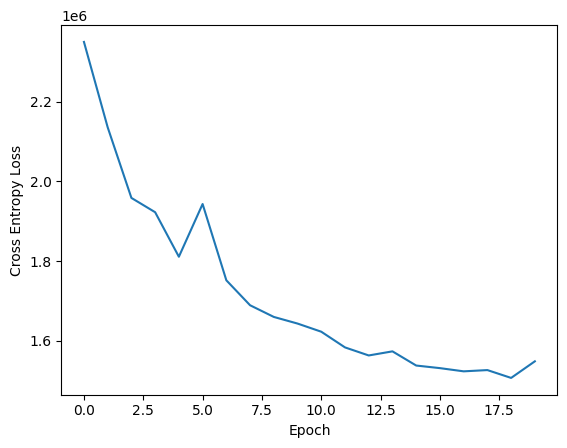

In [19]:
new_losses = []
for l in losses:
    new_losses.append(l.item())
plt.plot(new_losses)
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')

### Generating lyrics using the trained model


In [20]:

best_model, char_to_int = torch.load("single-char.pth")
n_vocab = len(char_to_int)
int_to_char = dict((i, c) for c, i in char_to_int.items())
model.load_state_dict(best_model)

<All keys matched successfully>

Generate a random prompt

In [21]:
start = np.random.randint(0, len(raw_text)-seq_length)
prompt = raw_text[start:start+seq_length]
pattern = [char_to_int[c] for c in prompt]

Sending the prompt to the model

In [22]:
model.eval()
print('Prompt:', prompt)
with torch.no_grad():
    for i in range(200):
        # format input array of int into PyTorch tensor
        x = np.reshape(pattern, (1, len(pattern), 1)) / float(n_vocab)
        x = torch.tensor(x, dtype=torch.float32)
        # generate logits as output from the model
        prediction = model(x.to(device))
        # convert logits into one character
        index = int(prediction.argmax())
        result = int_to_char[index]
        print(result, end="")
        # append the new character into the prompt for the next iteration
        pattern.append(index)
        pattern = pattern[1:]
print()
print("\nDone.")

Prompt: t, ooh, let me in once more
open up (your arms, i 
want to be the way you done and see you and the shine of the way
the way it's to can the shght whth you
and i want to be a sent
oh you and i want to be a sent
oh you can tell you thme
the way it was a

Done.
